## Brain MRI Project

For this project we will use some images of Brain MRIs and we will build a model that knows how to identify between the 4 classes that the images belong to.

The dataset is from [Kaggle](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset?select=Training). 
<br>It contains 7023 images, belonging to 4 different classes:  glioma - meningioma - no tumor and pituitary.
<br>Let us proceed with our imports and previewing the images.

#### Imports

In [42]:
from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import pandas as pd
import numpy as np
import os

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
from tensorflow.keras.constraints import MaxNorm
from scikeras.wrappers import KerasClassifier
from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from lime import lime_image
from skimage.segmentation import mark_boundaries
from skimage import io
from PIL import Image

#### Creating the datasets

In [19]:
# Directory path
train_data_dir = 'dataMRI/Training'
test_data_dir = 'dataMRI/Testing'

# Get all the data in the directory data/test
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir, batch_size=1311)

# Get all the data in the directory data/train
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, batch_size=5712)


# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 1311 images belonging to 4 classes.
Found 5712 images belonging to 4 classes.


Previewing an image from the train set:

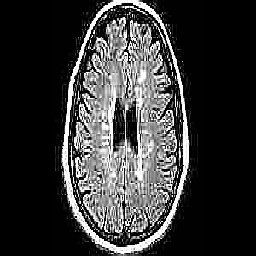

In [20]:
# Preview an image
array_to_img(train_images[0])

Previewing an image from the test set:

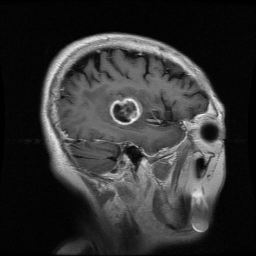

In [21]:
# Preview an image
array_to_img(test_images[0])

Now let us explore more the division among the classes and we will preview one image per class.

In [22]:
test_images.shape

(1311, 256, 256, 3)

In [23]:
train_images.shape

(5712, 256, 256, 3)

This shows us that the dimension of the imgaes is 256x256 and the sample that was taken from the image generator contains all the images for train and test.

Now we will generate a dataframe for the train images, first let us look at the classes:

In [24]:
train_generator.class_indices 

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [30]:
df_train=pd.DataFrame(train_labels, columns=['glioma', 'meningioma',\
            'notumor', 'pituitary'])

Let us preview it:

In [31]:
df_train

,glioma,meningioma,notumor,pituitary
0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0
...,...,...,...,...
5707,0.0,0.0,1.0,0.0
5708,0.0,0.0,0.0,1.0
5709,0.0,1.0,0.0,0.0
5710,0.0,1.0,0.0,0.0


In [35]:
df_train.value_counts()

glioma  meningioma  notumor  pituitary
0.0     0.0         1.0      0.0          1595
                    0.0      1.0          1457
        1.0         0.0      0.0          1339
1.0     0.0         0.0      0.0          1321
dtype: int64

In [37]:
sums=df_train.sum(axis=0)
sums=pd.DataFrame(sums)
sums.rename(columns={0: "Counts"}, inplace=True)
sums

,Counts
glioma,1321.0
meningioma,1339.0
notumor,1595.0
pituitary,1457.0


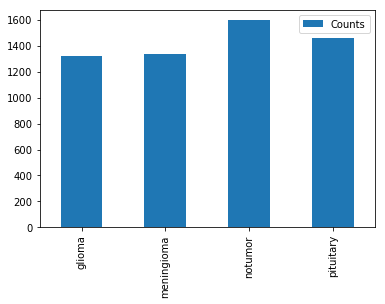

In [41]:
sums['Counts'].plot(kind='bar', legend=True);

#### Repeating for the test:

In [27]:
test_generator.class_indices 

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [32]:
df_test=pd.DataFrame(test_labels, columns=['glioma', 'meningioma',\
            'notumor', 'pituitary'])

In [33]:
df_test

,glioma,meningioma,notumor,pituitary
0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0
...,...,...,...,...
1306,0.0,0.0,0.0,1.0
1307,0.0,1.0,0.0,0.0
1308,0.0,0.0,0.0,1.0
1309,0.0,0.0,0.0,1.0


In [38]:
sums_test=df_test.sum(axis=0)
sums_test=pd.DataFrame(sums_test)
sums_test.rename(columns={0: "Counts"}, inplace=True)
sums_test

,Counts
glioma,300.0
meningioma,306.0
notumor,405.0
pituitary,300.0


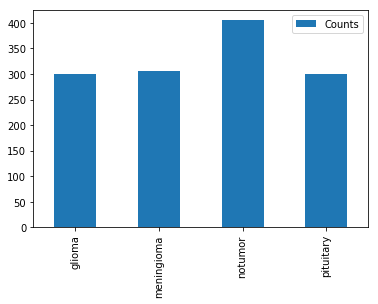

In [40]:
sums_test['Counts'].plot(kind='bar', legend=True);

Now that we saw the distribution of the images we can say that the classes are pretty well balanced and hopefully we shouldn't have problems of imbalanced classes.

#### Building some functions:

Building some functions that will help us visualize and compare the different models.
The first function we are defining is to visualize the curve of accuracy and loss, as they develop along the epochs, both for the train and validation set.
We are extracting these values from the history that the model produces once it is fit.

In [46]:
def visualize_training_results(results):
#Extracting the history from the results of the model
    history = results.history
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
#Plotting Train and Validation Accuracy
    ax1.plot(history['val_acc'])
    ax1.plot(history['acc'])
#Setting legend, title and labels
    ax1.legend(['val_acc', 'acc'], loc='best')
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
#Plotting Train and Validation Loss    
    ax2.plot(history['val_loss'])
    ax2.plot(history['loss'])
#Setting legend, title and labels
    ax2.legend(['val_loss', 'loss'], loc='best')
    ax2.set_title('Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')

Defining a function to fit the model and get the results. Also here we can set number of epochs, batch size and validation split, but there are default parameters too. In particular we set verbose to zero because we don't want to print out the fitting of all the models. We also set a default validation split of 20%, which is a standard amount, to have a part of the data that the model can do validation on.

In [47]:
#Defining function with some sest parameters
def fit_model(model, X, y, epo=15, batch=30, val_split=0.2, verbose=0):
    #Fitting the model and storing the results in the variable 'results'
    results = model.fit(X, y, epochs=epo, batch_size=batch, 
                        validation_split=val_split, verbose=verbose)
    return results

At last we are going to be creating a function to preview and store the results of our models. With this function we will display the evolution of accuracy and loss in our model, during the different epochs.
Below that we will see also the values of accuracy and loss and over time we will build a learning curve, adding the result of each previous model and the current one, to see if our model is improving.
We are also saving the results into a DataFrame that we will keep updating with the new results, to have them also in a convenient tabular format.

In [48]:
#Defining the function
def model_results(model, results, model_name, df, trainX, trainy ):
    #First we want the function to display the history of accuracy and loss, with the function previously defined
    visualize_training_results(results)
    #Creating a temporary DataFrame to store the results obtained
    df1 = pd.DataFrame({'Name': [model_name],
        'accuracy train': results.history['acc'][-1] ,
        'accuracy validation': results.history['val_acc'][-1],
        'loss train': results.history['loss'][-1],
        'loss validation': results.history['val_loss'][-1]})
    #Appending the results of the current model to the general DataFrame 'df' with results of all models
    df=df.append(df1)
    #Plotting learning curves of Accuracy and Loss
    fig = plt.subplots(figsize=(12,6))
    #First Subplot, accuracy of train and validation
    #This takes resulta from df, plotting the results from current and previous models
    plt.subplot(1,2,1)
    x=df['Name']
    y=df['accuracy train']
    plt.plot(x, y, color='c')
    x1=df['Name']
    y1=df['accuracy validation']
    plt.plot(x1, y1, color='m')
    plt.xticks(x, labels=df['Name'], rotation='vertical')
    plt.title('Learning Curve Accuracy')
    plt.legend()
    #Second Subplot, loss of train and validation
    plt.subplot(1,2,2)
    x=df['Name']
    y=df['loss train']
    plt.plot(x, y, color='c')
    x1=df['Name']
    y1=df['loss validation']
    plt.plot(x1, y1, color='m')
    plt.xticks(x, labels=df['Name'], rotation='vertical')
    plt.title('Learning Curve Loss')
    plt.legend()

    plt.show()
    return df

Next we are going to build a first naive CNN model that we will use as our baseline or naive model.

#### Naive Model:

Importing Images:

In [44]:
# Directory path
train_data_dir = 'dataMRI/Training'
test_data_dir = 'dataMRI/Testing'

# Get all the data in the directory data/test
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir,target_size=(16, 16), batch_size=1311)

# Get all the data in the directory data/train
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, target_size=(16, 16),batch_size=5712)


# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 1311 images belonging to 4 classes.
Found 5712 images belonging to 4 classes.


Creating a first basic model.
This model will have images of size 16x16 as input, and only one convolutional layer with 3 neurons, and one pooling layer.
The final Dense layer has to have 4 neurons because that corresponds with the number of classes that we are trying to identify for our images.

In [45]:
# create model
#Sequential: multiple layers built on top of each other

model = models.Sequential()
#Firs Convolutional Layer, with 3 neurons and 3X3 is the size of the filter
model.add(layers.Conv2D(3, (3, 3), activation='relu',
                        input_shape=(16,16,3)))
#MaxPooling with filter size 2 and stride 2
model.add(layers.MaxPooling2D(2,2))

#Flattening the last layer to be able to add the last Dense layer
model.add(layers.Flatten())
#Dense layer with 9 neurons (because of 9 classes)
model.add(layers.Dense(4, activation='softmax'))

# Compiling the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])